In [2]:
!pip uninstall -y opencv-python opencv-contrib-python
!pip install opencv-contrib-python==4.7.0.72

Found existing installation: opencv-python 4.11.0.86
Uninstalling opencv-python-4.11.0.86:
  Successfully uninstalled opencv-python-4.11.0.86
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Obtaining dependency information for opencv-contrib-python==4.7.0.72 from https://files.pythonhosted.org/packages/fb/89/8370c6864e518be9ca1b54a19b5daf398f4943041e1283ffa7ba0c66c0bd/opencv_contrib_python-4.7.0.72-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 MB 18.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
import torch
import cv2
import supervision as sv
from groundingdino.util.inference import Model
from segment_anything import sam_model_registry, SamPredictor
import numpy as np
import os

# 모델 가중치 및 설정 경로 (Dockerfile 기준)
GROUNDING_DINO_CONFIG_PATH = "/app/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_PATH = "/app/groundingdino/gdino_checkpoints/groundingdino_swint_ogc.pth"
SAM_CHECKPOINT_PATH = "/app/SAM/sam_vit_h_4b8939.pth"
SAM_ENCODER_VERSION = "vit_h"

# run_grounded_sam.py
def grounded_sam(img_path = "/app/images/KakaoTalk_20250520_140652269.jpg", text_prompt = "bus.wheel.window.", BOX_THRESHOLD = 0.35, TEXT_THRESHOLD = 0.25, output_dir = "outputs", save_img=False):
    # --- 설정 값 ---

    # 출력 폴더 생성
    os.makedirs(output_dir, exist_ok=True)
    
    # --- 모델 로딩 ---
    DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {DEVICE}")

    # GroundingDINO 모델 로드
    grounding_dino_model = Model(
        model_config_path=GROUNDING_DINO_CONFIG_PATH, 
        model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH,
        device=str(DEVICE)
    )

    # SAM 모델 로드
    sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
    sam_predictor = SamPredictor(sam)

    # --- 추론 실행 ---
    # 이미지 불러오기
    image_bgr = cv2.imread(img_path)
    if image_bgr is None:
        print(f"Error: 이미지를 읽을 수 없습니다. 경로를 확인하세요: {img_path}")
        return
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # 1. Grounding DINO로 Bounding Box 탐지
    detections = grounding_dino_model.predict_with_classes(
        image=image_rgb,
        classes=[c.strip() for c in text_prompt.split('.')],
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD
    )
    print(f"GroundingDINO found {len(detections)} objects.")

    # 2. 탐지된 BBox를 SAM의 입력으로 사용하여 Segmentation Mask 생성
    sam_predictor.set_image(image_rgb)
    boxes_for_sam = detections.xyxy
    
    if len(boxes_for_sam) > 0:
        masks, _, _ = sam_predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=torch.tensor(boxes_for_sam, device=sam_predictor.device),
            multimask_output=False,
        )
        detections.mask = masks.cpu().numpy().squeeze(1)
    else:
        # 객체가 탐지되지 않으면 마스크를 빈 배열로 설정
        detections.mask = np.empty((0, *image_bgr.shape[:2]), dtype=bool)

    # --- 결과 시각화 및 저장 ---
    # Annotator 생성
    box_annotator = sv.BoxAnnotator()
    mask_annotator = sv.MaskAnnotator()
    label_annotator = sv.LabelAnnotator()

    # 클래스 레이블 생성
    labels = [
        f"{text_prompt.split('.')[class_id]} {confidence:0.2f}"
        for class_id, confidence in zip(detections.class_id, detections.confidence)
    ]

    annotated_image = None
    if save_img==True:
        # 원본 이미지에 마스크와 BBox 그리기
        annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
        annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
        
        # 결과 이미지 저장
        output_filename = os.path.basename(img_path)
        output_path = os.path.join(output_dir, f"result_{output_filename}")
        cv2.imwrite(output_path, annotated_image)
        
        print(f"결과 이미지가 다음 경로에 저장되었습니다: {output_path}")

    return {
        'boxes': boxes_for_sam,
        'masks': masks,
        'class_ids': detections.class_id,
        'confidences': detections.confidence,
        'labels': labels,
        'annotated_image': annotated_image,
        'detections': detections
    }


In [4]:
result_grounded_sam = grounded_sam(img_path = "/app/images/KakaoTalk_20250520_140652269.jpg", text_prompt = "bus.wheel.window.", BOX_THRESHOLD = 0.35, TEXT_THRESHOLD = 0.25, output_dir = "outputs", save_img=True)

Using device: cuda:0


final text_encoder_type: bert-base-uncased


GroundingDINO found 3 objects.
결과 이미지가 다음 경로에 저장되었습니다: outputs/result_KakaoTalk_20250520_140652269.jpg


In [5]:
len(result_grounded_sam['boxes']), len(result_grounded_sam['masks']), len(result_grounded_sam['class_ids']), len(result_grounded_sam['confidences']), len(result_grounded_sam['labels']), len(result_grounded_sam['annotated_image']), len(result_grounded_sam['detections'])

(3, 3, 3, 3, 3, 3024, 3)

In [8]:
import matplotlib.pyplot as plt

def visualize_grounded_sam_result(result: dict, img_path: str = None, figsize=(12, 8)):
    """
    result: grounded_sam()이 반환한 dict.
      필수 키: 'detections' (sv.Detections 객체)
    img_path: 원본 BGR 이미지를 읽어올 경로. 
      result에 이미 'annotated_image'가 들어있다면 img_path 없이도 동작합니다.
    figsize: plt.figure 크기

    반환값: BGR 포맷으로 그려진 어노테이션 이미지 (numpy array)
    """
    detections = result['detections']
    
    # 1) 원본 이미지 로드
    if 'annotated_image' in result and result['annotated_image'] is not None and img_path is None:
        scene = result['annotated_image'].copy()
    else:
        if img_path is None:
            raise ValueError("annotated_image가 없으면 img_path를 반드시 지정해야 합니다.")
        scene = cv2.imread(img_path)
        if scene is None:
            raise FileNotFoundError(f"이미지를 읽을 수 없습니다: {img_path}")
    
    # 2) Annotator 준비
    mask_annotator  = sv.MaskAnnotator()
    box_annotator   = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    
    # 3) 차례대로 어노테이션 적용
    scene = mask_annotator.annotate(scene=scene, detections=detections)
    scene = box_annotator.annotate(scene=scene, detections=detections)
    scene = label_annotator.annotate(scene=scene, detections=detections)
    
    # 4) BGR → RGB 변환 후 출력
    rgb = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=figsize)
    plt.imshow(rgb)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return scene

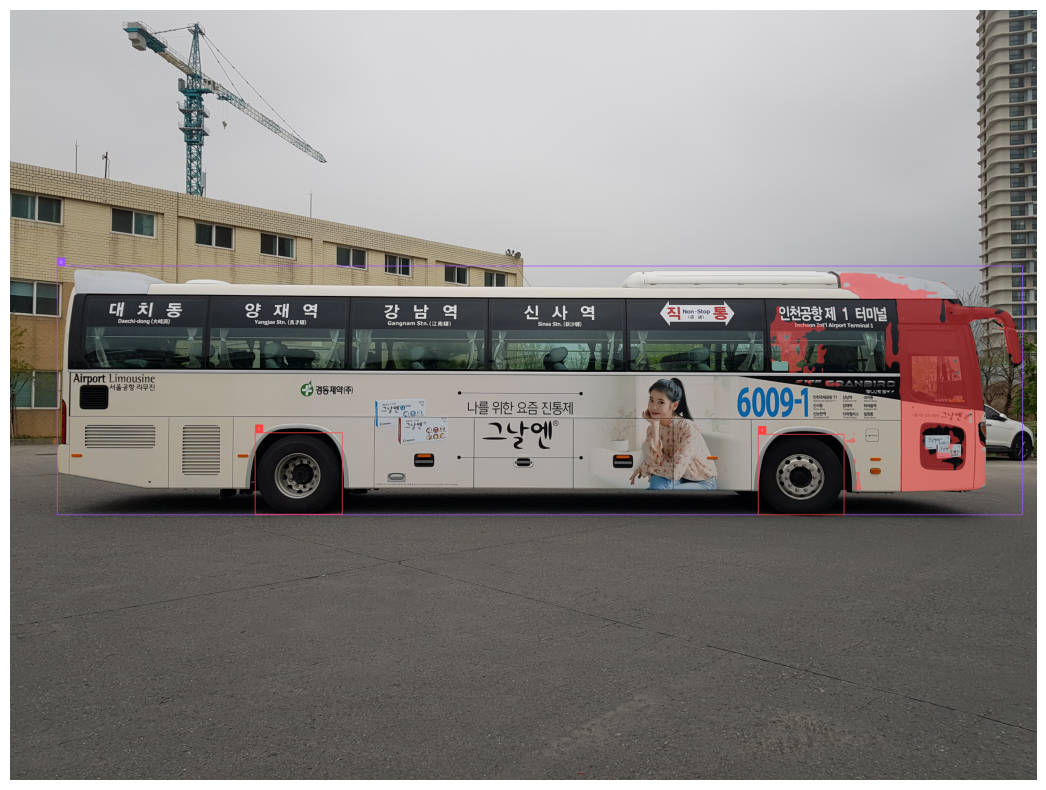

In [9]:
# 2) 시각화 함수 호출
annotated_bgr = visualize_grounded_sam_result(
    result_grounded_sam,
    img_path="/app/images/KakaoTalk_20250520_140652269.jpg"
)

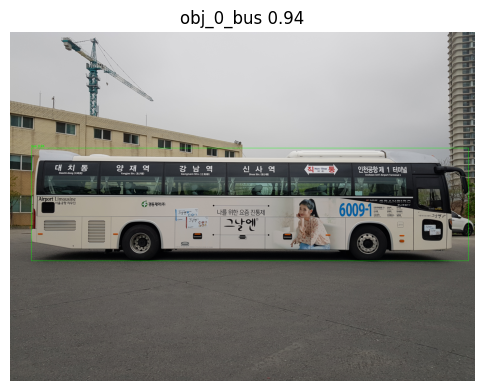

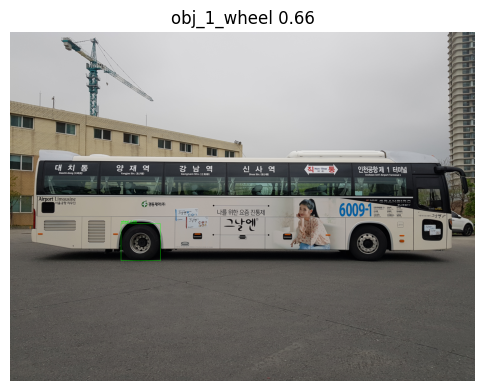

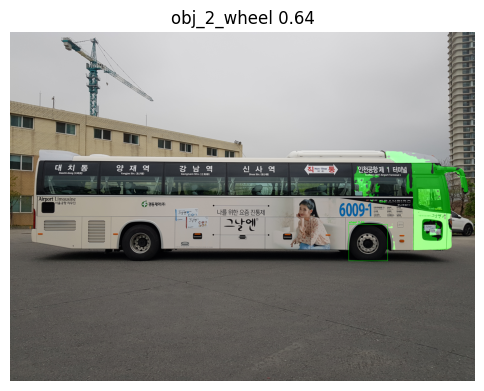

In [12]:
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np

# result_grounded_sam 호출에서 반환된 dict
res = result_grounded_sam

# 원본 BGR 이미지 다시 로드
img_path = "/app/images/KakaoTalk_20250520_140652269.jpg"
image_bgr = cv2.imread(img_path)

boxes      = res['boxes']        # ndarray, shape=(N,4)
masks      = res['masks']        # torch.Tensor, shape=(N,1,H,W) 혹은 (N,H,W)
labels     = res['labels']       # list of strings, length=N

for i, (box, mask, label) in enumerate(zip(boxes, masks, labels)):
    # 1) 원본 복제
    obj_img = image_bgr.copy()

    # 2) mask를 NumPy boolean 배열로 변환
    if isinstance(mask, torch.Tensor):
        # (N,1,H,W) 인 경우 squeeze, GPU 텐서라면 cpu()로 이동
        mask_np = mask.squeeze(0).cpu().numpy().astype(bool)
    else:
        mask_np = mask.astype(bool)

    # 3) 마스크 오버레이
    colored_mask = np.zeros_like(obj_img)
    colored_mask[mask_np] = (0, 255, 0)            # 녹색
    obj_img = cv2.addWeighted(obj_img, 1.0, colored_mask, 0.5, 0)

    # 4) BBox 그리기
    x1, y1, x2, y2 = box.astype(int)
    cv2.rectangle(obj_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # 5) 레이블 표시
    cv2.putText(obj_img, label, (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # 6) matplotlib 으로 인라인 표시
    plt.figure(figsize=(6,6))
    plt.title(f"obj_{i}_{label}")
    plt.axis('off')
    plt.imshow(cv2.cvtColor(obj_img, cv2.COLOR_BGR2RGB))
    plt.show()


In [ ]:
# 2) 시각화 함수 호출
annotated_bgr = visualize_grounded_sam_result(
    result,
    img_path="/app/images/KakaoTalk_20250520_140652269.jpg"
)

Using device: cuda:0
final text_encoder_type: bert-base-uncased


TypeError: '<' not supported between instances of 'NoneType' and 'int'

In [7]:
import torch
import cv2
import supervision as sv
from groundingdino.util.inference import Model
from segment_anything import sam_model_registry, SamPredictor
import numpy as np
import os

def process_image_with_grounded_sam(image_path: str, text_prompt: str):
    """
    Grounding DINO를 사용하여 객체를 탐지하고 SAM을 사용하여 분할 마스크를 생성합니다.

    Args:
        image_path (str): 입력 이미지 파일의 경로입니다.
        text_prompt (str): 탐지할 객체를 쉼표로 구분한 문자열입니다 (예: "bus, wheel, window").

    Returns:
        tuple: 다음을 포함하는 튜플입니다:
            - boxes (list[list[float]]): 각 탐지된 객체의 바운딩 박스 좌표 목록 (x1, y1, x2, y2).
            - masks (list[np.ndarray]): 각 탐지된 객체의 이진 분할 마스크 목록.
            - labels (list[str]): 각 탐지 결과에 대한 "클래스_이름 신뢰도_점수" 형식의 레이블 목록.
            - class_ids (list[int]): 각 탐지 결과에 대한 클래스 ID 목록.
            - confidences (list[float]): 각 탐지 결과에 대한 신뢰도 점수 목록.
    """
    # --- 설정 값 ---
    # 모델 파라미터
    BOX_THRESHOLD = 0.35
    TEXT_THRESHOLD = 0.25

    # 모델 가중치 및 설정 경로 (Dockerfile 기준)
    GROUNDING_DINO_CONFIG_PATH = "/app/groundingdino/config/GroundingDINO_SwinT_OGC.py"
    GROUNDING_DINO_CHECKPOINT_PATH = "/app/groundingdino/gdino_checkpoints/groundingdino_swint_ogc.pth"
    SAM_CHECKPOINT_PATH = "/app/SAM/sam_vit_h_4b8939.pth"
    SAM_ENCODER_VERSION = "vit_h"
    
    # --- 모델 로딩 ---
    DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"사용 장치: {DEVICE}")

    # GroundingDINO 모델 로드
    grounding_dino_model = Model(
        model_config_path=GROUNDING_DINO_CONFIG_PATH, 
        model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH,
        device=str(DEVICE)
    )

    # SAM 모델 로드
    sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
    sam_predictor = SamPredictor(sam)

    # --- 추론 실행 ---
    # 이미지 불러오기
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        print(f"오류: 이미지를 읽을 수 없습니다. 경로를 확인하세요: {image_path}")
        return [], [], [], [], [] # 이미지 로드 실패 시 빈 리스트 반환
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # 1. Grounding DINO로 Bounding Box 탐지
    classes_list = [c.strip() for c in text_prompt.split(',')]
    detections = grounding_dino_model.predict_with_classes(
        image=image_rgb,
        classes=classes_list,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD
    )
    print(f"GroundingDINO에서 {len(detections)}개의 객체를 찾았습니다.")

    # 2. 탐지된 BBox를 SAM의 입력으로 사용하여 Segmentation Mask 생성
    sam_predictor.set_image(image_rgb)
    boxes_for_sam = detections.xyxy
    
    if len(boxes_for_sam) > 0:
        masks, _, _ = sam_predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=torch.tensor(boxes_for_sam, device=sam_predictor.device),
            multimask_output=False,
        )
        detections.mask = masks.cpu().numpy().squeeze(1)
    else:
        # 객체가 탐지되지 않으면 마스크를 빈 배열로 설정
        detections.mask = np.empty((0, *image_bgr.shape[:2]), dtype=bool)

    # 반환할 값 준비
    boxes = detections.xyxy.tolist() if detections.xyxy is not None else []
    masks = detections.mask.tolist() if detections.mask is not None else []
    confidences = detections.confidence.tolist() if detections.confidence is not None else []
    class_ids = detections.class_id.tolist() if detections.class_id is not None else []

    # 출력용 레이블 생성
    labels = []
    for class_id, confidence in zip(class_ids, confidences):
        if class_id < len(classes_list): # class_id가 classes_list 범위 내에 있는지 확인
            labels.append(f"{classes_list[class_id]} {confidence:0.2f}")
        else:
            labels.append(f"UNKNOWN {confidence:0.2f}") # 범위를 벗어난 class_id에 대한 대체

    # --- 결과 시각화 및 저장 (선택 사항 - 디버깅/확인용) ---
    # 반환된 데이터만 필요하다면 이 섹션을 주석 처리하거나 제거할 수 있습니다.
    OUTPUT_DIR = "outputs"
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    box_annotator = sv.BoxAnnotator()
    mask_annotator = sv.MaskAnnotator()
    
    annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
    
    output_filename = os.path.basename(image_path)
    output_path = os.path.join(OUTPUT_DIR, f"result_{output_filename}")
    cv2.imwrite(output_path, annotated_image)
    print(f"결과 이미지가 다음 경로에 저장되었습니다: {output_path}")

    return boxes, masks, labels, class_ids, confidences

if __name__ == "__main__":
    # 사용 예시:
    IMAGE_PATH = "/app/images/KakaoTalk_20250520_140652269.jpg"
    TEXT_PROMPT = "bus. wheel. window."

    detected_boxes, detected_masks, detected_labels, detected_class_ids, detected_confidences = \
        process_image_with_grounded_sam(IMAGE_PATH, TEXT_PROMPT)

    print("\n--- 탐지 결과 ---")
    print(f"{len(detected_boxes)}개의 객체를 탐지했습니다.")
    for i, (box, mask, label, class_id, confidence) in enumerate(zip(detected_boxes, detected_masks, detected_labels, detected_class_ids, detected_confidences)):
        print(f"객체 {i+1}:")
        print(f"  레이블: {label}")
        print(f"  바운딩 박스: {box}")
        print(f"  마스크 형태: {mask.shape if isinstance(mask, np.ndarray) else 'N/A'}")
        print(f"  클래스 ID: {class_id}")
        print(f"  신뢰도: {confidence:.2f}")

사용 장치: cuda:0
final text_encoder_type: bert-base-uncased
GroundingDINO에서 3개의 객체를 찾았습니다.


TypeError: '<' not supported between instances of 'NoneType' and 'int'